# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.07KFile/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

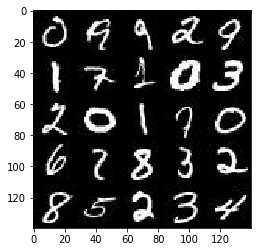

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

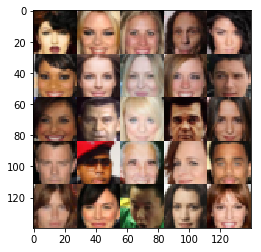

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/bella/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None,image_height,image_width,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    keep_prob=0.7
    with tf.variable_scope('discriminator',reuse=reuse):
        images = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * images, images)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        dropped = tf.layers.dropout(bn3,keep_prob)
        relu3 = tf.maximum(alpha * dropped, dropped)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse= not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*112)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 112))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x112 now
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x56 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)* 0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)* 0.9))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    _,i_height,i_width,i_channels=data_shape
    image_channels=3 if data_image_mode=="RGB" else 1
    input_real, input_z, lr = model_inputs(i_height, i_width, i_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,i_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    count=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images , input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,input_real: batch_images,lr:learning_rate})

                losses = []
                if count%20==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch: {}/{}'.format(epoch_i + 1, epoch_count),
                          'Discriminator Loss: {}'.format(train_loss_d),
                          'Generator Loss: {}'.format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                if count%200==0:
                    show_generator_output(sess, 25, input_z, i_channels, data_image_mode)
                count+=1
                
        show_generator_output(sess, 25, input_z, i_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch: 1/2 Discriminator Loss: 8.150049209594727 Generator Loss: 0.0012134603457525373


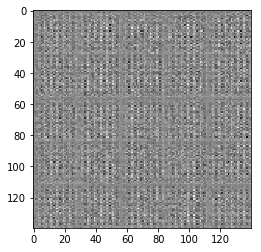

Epoch: 1/2 Discriminator Loss: 1.0342601537704468 Generator Loss: 0.8609240651130676
Epoch: 1/2 Discriminator Loss: 0.9800024032592773 Generator Loss: 2.7794220447540283
Epoch: 1/2 Discriminator Loss: 2.4413373470306396 Generator Loss: 5.490601539611816
Epoch: 1/2 Discriminator Loss: 0.5940770506858826 Generator Loss: 1.2837729454040527
Epoch: 1/2 Discriminator Loss: 0.4868960976600647 Generator Loss: 1.5620911121368408
Epoch: 1/2 Discriminator Loss: 0.5494468808174133 Generator Loss: 2.645204544067383
Epoch: 1/2 Discriminator Loss: 0.3369092643260956 Generator Loss: 2.4497108459472656
Epoch: 1/2 Discriminator Loss: 1.3756428956985474 Generator Loss: 3.375890016555786
Epoch: 1/2 Discriminator Loss: 1.37686288356781 Generator Loss: 6.360282897949219
Epoch: 1/2 Discriminator Loss: 0.9512971639633179 Generator Loss: 0.5936828851699829


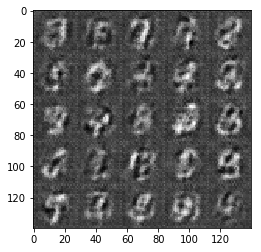

Epoch: 1/2 Discriminator Loss: 0.17676925659179688 Generator Loss: 3.031156063079834
Epoch: 1/2 Discriminator Loss: 0.286865234375 Generator Loss: 1.9355804920196533
Epoch: 1/2 Discriminator Loss: 0.17652393877506256 Generator Loss: 2.4446492195129395
Epoch: 1/2 Discriminator Loss: 0.685145914554596 Generator Loss: 4.023674011230469
Epoch: 1/2 Discriminator Loss: 0.12402500957250595 Generator Loss: 4.35436487197876
Epoch: 1/2 Discriminator Loss: 1.0675663948059082 Generator Loss: 1.0484678745269775
Epoch: 1/2 Discriminator Loss: 0.2702104449272156 Generator Loss: 2.012688398361206
Epoch: 1/2 Discriminator Loss: 0.4057137370109558 Generator Loss: 4.235004425048828
Epoch: 1/2 Discriminator Loss: 1.170719027519226 Generator Loss: 3.3819258213043213
Epoch: 1/2 Discriminator Loss: 0.4080182909965515 Generator Loss: 1.4604082107543945


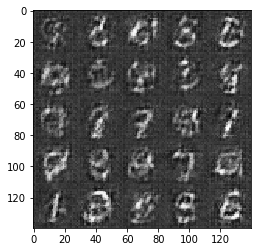

Epoch: 1/2 Discriminator Loss: 0.23755788803100586 Generator Loss: 2.1288161277770996
Epoch: 1/2 Discriminator Loss: 0.19320213794708252 Generator Loss: 2.5596659183502197
Epoch: 1/2 Discriminator Loss: 0.16825254261493683 Generator Loss: 2.4265851974487305
Epoch: 2/2 Discriminator Loss: 0.16824202239513397 Generator Loss: 2.311495065689087
Epoch: 2/2 Discriminator Loss: 0.10016841441392899 Generator Loss: 2.8235349655151367
Epoch: 2/2 Discriminator Loss: 0.13031165301799774 Generator Loss: 2.4886345863342285
Epoch: 2/2 Discriminator Loss: 0.07402403652667999 Generator Loss: 3.0096521377563477
Epoch: 2/2 Discriminator Loss: 0.07434895634651184 Generator Loss: 3.1205856800079346
Epoch: 2/2 Discriminator Loss: 3.8339943885803223 Generator Loss: 4.9344916343688965
Epoch: 2/2 Discriminator Loss: 1.3084207773208618 Generator Loss: 0.8555787801742554


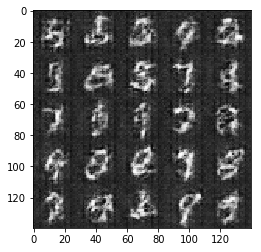

Epoch: 2/2 Discriminator Loss: 0.952116072177887 Generator Loss: 1.3786674737930298
Epoch: 2/2 Discriminator Loss: 0.9954566955566406 Generator Loss: 0.6592166423797607
Epoch: 2/2 Discriminator Loss: 1.3972654342651367 Generator Loss: 3.048487663269043
Epoch: 2/2 Discriminator Loss: 0.9060506224632263 Generator Loss: 0.9718275666236877
Epoch: 2/2 Discriminator Loss: 0.6464698314666748 Generator Loss: 0.9752830862998962
Epoch: 2/2 Discriminator Loss: 0.8709075450897217 Generator Loss: 0.662143349647522
Epoch: 2/2 Discriminator Loss: 0.4898764491081238 Generator Loss: 1.5052692890167236
Epoch: 2/2 Discriminator Loss: 0.38519173860549927 Generator Loss: 1.4856852293014526
Epoch: 2/2 Discriminator Loss: 0.3752349019050598 Generator Loss: 1.4210636615753174
Epoch: 2/2 Discriminator Loss: 0.24059832096099854 Generator Loss: 1.8462200164794922


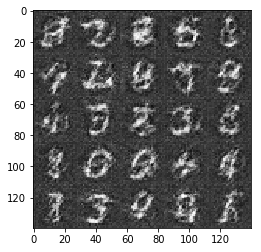

Epoch: 2/2 Discriminator Loss: 0.17080934345722198 Generator Loss: 2.1814050674438477
Epoch: 2/2 Discriminator Loss: 0.1818331927061081 Generator Loss: 2.134929656982422
Epoch: 2/2 Discriminator Loss: 0.10170383006334305 Generator Loss: 2.8534014225006104
Epoch: 2/2 Discriminator Loss: 0.051153991371393204 Generator Loss: 3.3934526443481445
Epoch: 2/2 Discriminator Loss: 0.05091843008995056 Generator Loss: 3.478863477706909
Epoch: 2/2 Discriminator Loss: 0.0935952290892601 Generator Loss: 2.825868844985962


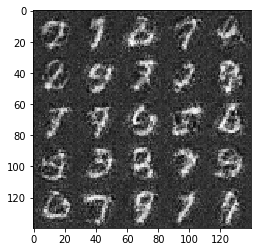

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch: 1/1 Discriminator Loss: 0.7326271533966064 Generator Loss: 0.9598652124404907


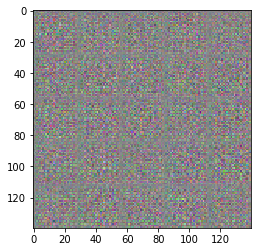

Epoch: 1/1 Discriminator Loss: 0.07101111114025116 Generator Loss: 3.1981191635131836
Epoch: 1/1 Discriminator Loss: 0.046626053750514984 Generator Loss: 3.8024370670318604
Epoch: 1/1 Discriminator Loss: 0.02856014296412468 Generator Loss: 4.292488098144531
Epoch: 1/1 Discriminator Loss: 0.026201145723462105 Generator Loss: 4.499104976654053
Epoch: 1/1 Discriminator Loss: 0.027554333209991455 Generator Loss: 4.2212324142456055
Epoch: 1/1 Discriminator Loss: 0.031084559857845306 Generator Loss: 4.520340919494629
Epoch: 1/1 Discriminator Loss: 0.12542249262332916 Generator Loss: 3.2634458541870117
Epoch: 1/1 Discriminator Loss: 0.10864076018333435 Generator Loss: 3.0642690658569336
Epoch: 1/1 Discriminator Loss: 0.09067340195178986 Generator Loss: 3.0951027870178223
Epoch: 1/1 Discriminator Loss: 0.04468248784542084 Generator Loss: 4.025907516479492


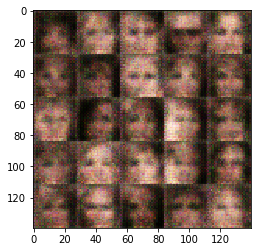

Epoch: 1/1 Discriminator Loss: 0.09413281828165054 Generator Loss: 2.918980836868286
Epoch: 1/1 Discriminator Loss: 0.039528053253889084 Generator Loss: 6.618537902832031
Epoch: 1/1 Discriminator Loss: 0.06366916745901108 Generator Loss: 3.6525890827178955
Epoch: 1/1 Discriminator Loss: 0.16177962720394135 Generator Loss: 2.421536922454834
Epoch: 1/1 Discriminator Loss: 0.15670707821846008 Generator Loss: 3.8769450187683105
Epoch: 1/1 Discriminator Loss: 0.7842097282409668 Generator Loss: 3.6425821781158447
Epoch: 1/1 Discriminator Loss: 0.42990490794181824 Generator Loss: 1.841854453086853
Epoch: 1/1 Discriminator Loss: 0.26848772168159485 Generator Loss: 2.194455862045288
Epoch: 1/1 Discriminator Loss: 0.4276866912841797 Generator Loss: 1.58951997756958
Epoch: 1/1 Discriminator Loss: 0.2491503208875656 Generator Loss: 2.3419322967529297


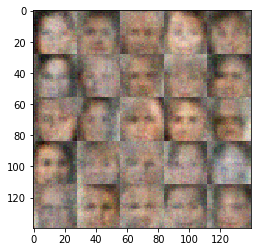

Epoch: 1/1 Discriminator Loss: 0.2495127171278 Generator Loss: 2.5013442039489746
Epoch: 1/1 Discriminator Loss: 0.2195364087820053 Generator Loss: 2.379364013671875
Epoch: 1/1 Discriminator Loss: 0.27432796359062195 Generator Loss: 2.119478702545166
Epoch: 1/1 Discriminator Loss: 0.34765031933784485 Generator Loss: 1.6241638660430908
Epoch: 1/1 Discriminator Loss: 0.19850541651248932 Generator Loss: 2.346242666244507
Epoch: 1/1 Discriminator Loss: 0.23656821250915527 Generator Loss: 2.0339322090148926
Epoch: 1/1 Discriminator Loss: 1.4617516994476318 Generator Loss: 2.876150131225586
Epoch: 1/1 Discriminator Loss: 0.2548811733722687 Generator Loss: 2.0907998085021973
Epoch: 1/1 Discriminator Loss: 0.21834197640419006 Generator Loss: 2.509197235107422
Epoch: 1/1 Discriminator Loss: 0.2188628762960434 Generator Loss: 2.67388916015625


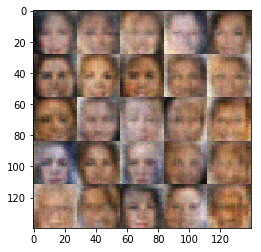

Epoch: 1/1 Discriminator Loss: 0.1966850757598877 Generator Loss: 2.4904327392578125
Epoch: 1/1 Discriminator Loss: 0.29641473293304443 Generator Loss: 3.0351552963256836
Epoch: 1/1 Discriminator Loss: 0.1882518231868744 Generator Loss: 2.498828411102295
Epoch: 1/1 Discriminator Loss: 0.18290656805038452 Generator Loss: 2.528571367263794
Epoch: 1/1 Discriminator Loss: 0.1962548941373825 Generator Loss: 2.2589213848114014
Epoch: 1/1 Discriminator Loss: 0.2095392644405365 Generator Loss: 2.6432244777679443
Epoch: 1/1 Discriminator Loss: 1.8920693397521973 Generator Loss: 6.396636962890625
Epoch: 1/1 Discriminator Loss: 0.20965638756752014 Generator Loss: 2.994215965270996
Epoch: 1/1 Discriminator Loss: 0.1766807585954666 Generator Loss: 2.614699602127075
Epoch: 1/1 Discriminator Loss: 0.24096660315990448 Generator Loss: 2.252703905105591


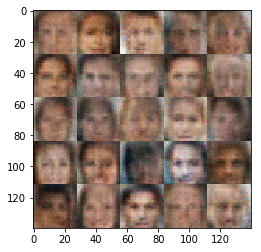

Epoch: 1/1 Discriminator Loss: 0.33413320779800415 Generator Loss: 1.7991948127746582
Epoch: 1/1 Discriminator Loss: 0.20771557092666626 Generator Loss: 3.18497633934021
Epoch: 1/1 Discriminator Loss: 0.16233189404010773 Generator Loss: 2.9387333393096924
Epoch: 1/1 Discriminator Loss: 0.20662245154380798 Generator Loss: 3.003476858139038
Epoch: 1/1 Discriminator Loss: 0.1950787603855133 Generator Loss: 2.709817886352539
Epoch: 1/1 Discriminator Loss: 1.192876935005188 Generator Loss: 2.6929116249084473
Epoch: 1/1 Discriminator Loss: 0.2732202410697937 Generator Loss: 2.4369235038757324
Epoch: 1/1 Discriminator Loss: 0.27220040559768677 Generator Loss: 2.2180252075195312
Epoch: 1/1 Discriminator Loss: 0.22939573228359222 Generator Loss: 2.4918274879455566
Epoch: 1/1 Discriminator Loss: 0.20587016642093658 Generator Loss: 3.1712796688079834


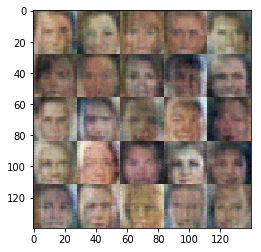

Epoch: 1/1 Discriminator Loss: 0.32898205518722534 Generator Loss: 2.476475715637207


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.